In [1]:
import numpy as np
from numpy import vectorize
from scipy import interpolate, integrate
from scipy import special
from scipy.interpolate import UnivariateSpline, InterpolatedUnivariateSpline, interp1d
from scipy.ndimage.filters import gaussian_filter
from astropy.cosmology import FlatLambdaCDM
from colossus.cosmology import cosmology
from colossus.halo import mass_adv
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('default')
import timeit

def battaglia_profile(r, Mvir, z, BryanDelta, rho_critical, omega_b0, omega_m0, cosmo_h):
    '''
    Using Battaglia et al (2012). Eq. 10. 
    Input: M200 in solar mass and R200 in Mpc
    Return: Pressure profile in keV/cm^3 at radius r
    '''
    params = {'flat': True, 'H0': 70, 'Om0': 0.27, 'Ob0': 0.044, 'sigma8': 0.80, 'ns': 0.95}
    cosmology.addCosmology('myCosmo', **params)
    cosmo = cosmology.setCosmology('myCosmo')
#     cvir = concentration.concentration(Mvir, 'vir', z, model = 'ishiyama21')      #Ishiyama et al. (2021)
    M200, R200, c200 = mass_adv.changeMassDefinitionCModel(Mvir/cosmo_h, z, 'vir', '200c')
    M200 *= cosmo_h
    R200 = R200 / 1000 * cosmo_h
    
    R200 *= (1. + z)                            # Proper distance to Comoving distance
    x = r / R200
    msolar = 1.9889e30                          # kg
    mpc2cm = 3.0856e24
    G = 4.3e-9                                  # Mpc Mo^-1 (km/s)^2 
    alpha = 1.0
    gamma = -0.3
    P200 = 200. * rho_critical * omega_b0 * G * M200 / omega_m0 / 2. / (R200 / (1. + z))    # Msun km^2 / Mpc^3 / s^2

    P0 = 18.1 * ((M200 / 1e14)**0.154 * (1. + z)**-0.758)
    xc = 0.497 * ((M200 / 1e14)**-0.00865 * (1. + z)**0.731)
    
    beta = 4.35 * ((M200 / 1e14)**0.0393 * (1. + z)**0.415) 
    pth = P200 * P0 * (x / xc)**gamma * (1. + (x/xc))**(-1. * beta)      # Msun km^2 / Mpc^3 / s^2

    pth *= (msolar * 6.24e15 * 1e6 / mpc2cm**3)       # keV/cm^3
    p_e = pth * 0.518       # Vikram et al (2016)
    return p_e


def make_proj_image_new(radius, profile,maxRadius=5,pixel_scale=0.05,extrapolate=False):
        image_size = np.int_(np.round(maxRadius*2/pixel_scale)/2+1)

        if extrapolate:
            profile_spline = interp1d(radius, profile, kind = 3, bounds_error=False, fill_value="extrapolate")
        else:
            profile_spline = interp1d(radius, profile, bounds_error=False)

        x,y=np.meshgrid(np.arange(image_size),np.arange(image_size))
        r = np.sqrt((x-image_size//2)**2+(y-image_size//2)**2)*pixel_scale
        image = profile_spline(r)
        return image
    
def make_proj_image_new_2(radius, profile,maxRadius=0.5,pixel_scale=0.005,extrapolate=False):
        image_size = np.int_(np.round(maxRadius*2/pixel_scale)/2+1)

        if extrapolate:
            profile_spline = interp1d(radius, profile, kind = 3, bounds_error=False, fill_value="extrapolate")
        else:
            profile_spline = interp1d(radius, profile, bounds_error=False)

        x,y=np.meshgrid(np.arange(image_size),np.arange(image_size))
        r = np.sqrt((x-image_size//2)**2+(y-image_size//2)**2)*pixel_scale
        image = profile_spline(r)
        return image
    
def f_sz(f, T_CMB):
    planck_const = 6.626e-34         #m^2 kg/s
    boltzman_const = 1.38e-23
    x = planck_const * f / boltzman_const / T_CMB
    return x * (np.exp(x) + 1) / (np.exp(x) - 1) - 4

def Mpc_to_arcmin(r, redshift):
    cosmo = FlatLambdaCDM(H0=70, Om0=0.27)
    Kpc_per_arcmin = cosmo.kpc_comoving_per_arcmin(redshift).value
    Mpc_per_arcmin = Kpc_per_arcmin/1000
    return r / Mpc_per_arcmin

def plot_img(image, mode = 1, cmb = 0):
    if mode:    # 0.5 Mpc
        values = [-0.4, -0.2, 0, 0.2, 0.4]
        e = [-0.5, 0.5, -0.5, 0.5]
    else:   # 5 Mpc
        values = [-4, -2, 0, 2, 4]
        e = [-5, 5, -5, 5]
    if cmb:
        option = 'ocean'
        title = '$\Delta$T'
        cbar_label = r'$uK$'
    else:
        option = 'hot'
        title = 'Y'
        cbar_label = r'$Y$'
        if mode == 0:
            cbar_label = r'$\log_{10}Y$'
    fig, ax = plt.subplots(1,1)
    img = ax.imshow(image, cmap=option, extent = e)
    x_label_list = Mpc_to_arcmin(values, redshift)
    x_label_list = np.round(x_label_list)
    ax.set_xticks(values)
    ax.set_xticklabels(x_label_list)
    cbar = fig.colorbar(img)
    cbar.ax.set_ylabel(cbar_label)
    plt.title(title)
    plt.xlabel('arcmin')
    plt.ylabel(r'Mpc')

In [2]:
#Variable inputs
Mass = 1e13
redshift = 0.1

a = 1.0/(1.0 + redshift)
E0 = 0.73 + 0.27/(a*a*a) + 0./(a*a)
x = 0.27 - 1
BryanDelta = 18 * np.pi * np.pi + 82. * x - 39. * x * x
rho_crit = 1.879/(1.989)*3.086**3*1e10 * E0
rho_critical = rho_crit * 0.7 * 0.7
omega_b0 = 0.044
omega_m0 = 0.27
cosmo_h = 0.7
radius = np.linspace(0.1, 2, 10)

In [3]:
battaglia_pro = np.array([battaglia_profile(r, Mass, redshift, BryanDelta, rho_critical, omega_b0, omega_m0, cosmo_h) for r in np.linspace(0.1, 2, 10)])
constant = 6.65246e-29 / (9.11e-31) / ((3.0e8) ** 2)         #s^2/kg
Mpc_to_m = 3.09e22
kevcm_to_im = 1.6e-16 * 1e6
new_battaglia = battaglia_pro * kevcm_to_im
y_pro = new_battaglia * constant * Mpc_to_m

Deleted outdated persistence file, no further action needed.
Deleted outdated persistence file, no further action needed.
Deleted outdated persistence file, no further action needed.
Deleted outdated persistence file, no further action needed.
Deleted outdated persistence file, no further action needed.
Deleted outdated persistence file, no further action needed.
Deleted outdated persistence file, no further action needed.
Deleted outdated persistence file, no further action needed.
Deleted outdated persistence file, no further action needed.
Deleted outdated persistence file, no further action needed.
Deleted outdated persistence file, no further action needed.


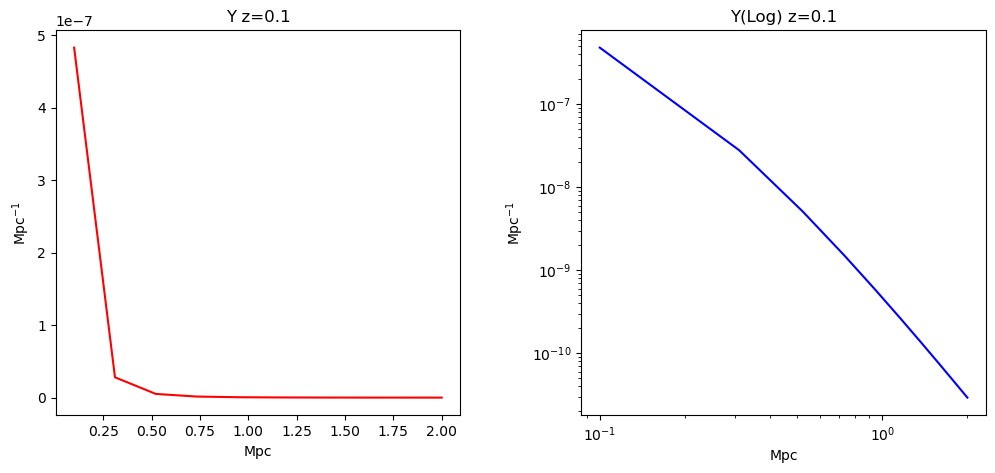

In [4]:
fig,ax = plt.subplots(1,2,figsize = (12,5))
plt.subplots_adjust(wspace = 0.3)
ax[0].plot(radius, y_pro, color = "red", label = "non-log")
ax[0].set_xlabel("Mpc")
ax[0].set_ylabel(r'Mpc$^{-1}$')
ax[0].title.set_text("Y z="+str(redshift))
ax[1].loglog(radius, y_pro, color = "blue", label = "log")
ax[1].set_xlabel("Mpc")
ax[1].set_ylabel(r'Mpc$^{-1}$')
ax[1].title.set_text("Y(Log) z="+str(redshift))
plt.show()

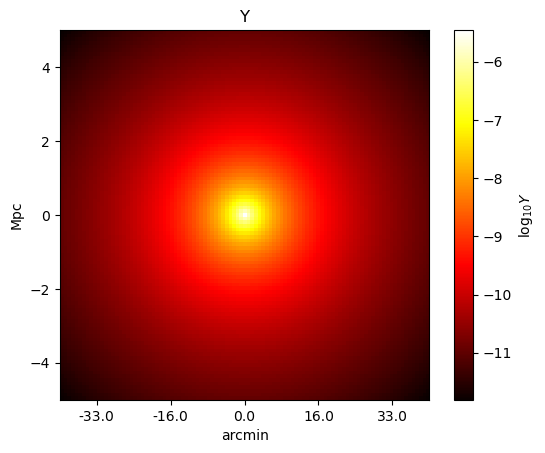

In [5]:
log_image = make_proj_image_new(radius,np.log10(y_pro),extrapolate=True)
plot_img(log_image, 0)

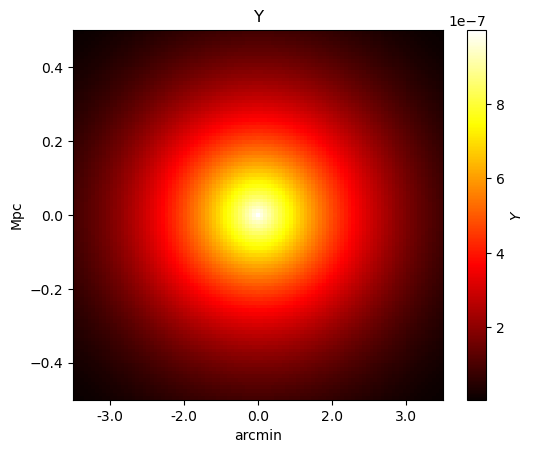

In [6]:
y_img = make_proj_image_new_2(radius,y_pro,extrapolate=True)
plot_img(y_img)

## Mapping from Compton-Y to CMB

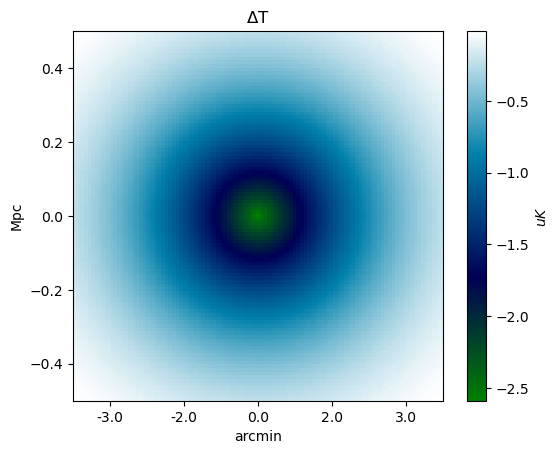

In [7]:
f = 1.5e11               #Hz
t_cmb = 2.725            #K
fsz = f_sz(f, t_cmb)
cmb_img = y_img * fsz * t_cmb * 1e6
plot_img(cmb_img, cmb = 1)

## White Noise

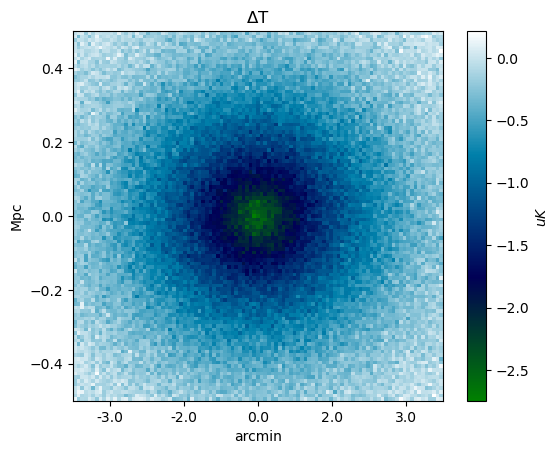

In [8]:
noise_level = 0.1                      #Can change level
noise = np.random.normal(0, 1, (101,101)) * noise_level
CMB_noise = cmb_img + noise
plot_img(CMB_noise, cmb = 1)

## Mapping from CMB to Compton-Y

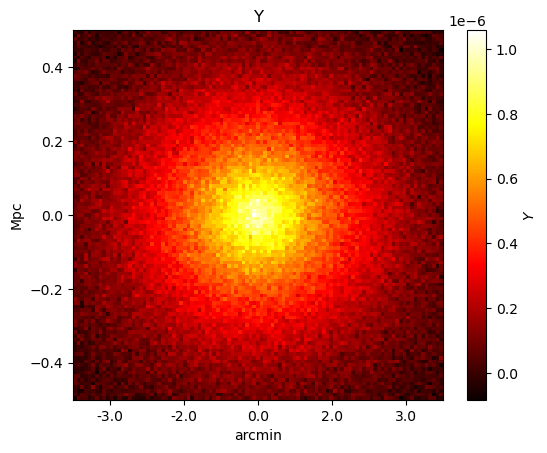

In [9]:
y_noise = CMB_noise / fsz / t_cmb / 1e6
plot_img(y_noise)